# Lending Club Analysis Using AutoML

In this tutorial, we will go through a step-by-step workflow to build models using AML to determine loan deliquency. We will make predictions based only on the information available at the time the loan was issued.  The data for this exercise come from the public Lending Club data set, a description can be found [here](https://www.kaggle.com/pragyanbo/a-hitchhiker-s-guide-to-lending-club-loan-data/notebook).

We will highlight data cleaning and feature engineering that will improve model performance.

## Workflow

1. Start H2O-3 cluster
2. Import data
3. Train default models using H2O's AutoML
4. Feature engineering to improve model performance
5. Train models using transformed data with AutoML
6. Stop H2O-3 cluster

# Step 1 (of 6). Start H2O Cluster

In [1]:
import h2o
h2o.init(max_mem_size = "6g")

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_212"; OpenJDK Runtime Environment (build 1.8.0_212-8u212-b03-0ubuntu1.18.04.1-b03); OpenJDK 64-Bit Server VM (build 25.212-b03, mixed mode)
  Starting server from /home/h2o/bin/miniconda3/envs/h2o/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp4c0evpx6
  JVM stdout: /tmp/tmp4c0evpx6/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp4c0evpx6/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.5
H2O cluster version age:,1 month and 22 days
H2O cluster name:,H2O_from_python_unknownUser_3ec8ez
H2O cluster total nodes:,1
H2O cluster free memory:,5.333 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


# Step 2 (of 6). Import Data

This exploration of H2O will use a version of the Lending Club Loan Data that can be found on [Kaggle](https://www.kaggle.com/wendykan/lending-club-loan-data). This data consists of 15 variables:

|  Id   | Column Name | Description |
| --- | ----------- | ----------- |
|   1 | loan_amnt   | Requested loan amount (US dollars) |
|   2 | term        | Loan term length (months) |
|   3 | int_rate    | Recommended interest rate |
|   4 | emp_length  | Employment length (years) |
|   5 | home_ownership| Housing status |
|   6 | annual_inc  | Annual income (US dollars) |
|   7 | purpose     | Purpose for the loan |
|   8 | addr_state  | State of residence |
|   9 | dti         | Debt to income ratio |
|  10 | delinq_2yrs | Number of delinquencies in the past 2 years |
|  11 | revol_util  | Percent of revolving credit line utilized |
|  12 | total_acc   | Number of active accounts |
|  13 | bad_loan    | Bad loan indicator |
|  14 | longest_credit_length | Age of oldest active account |
|  15 | verification_status | Income verification status |

In [2]:
# https://s3-us-west-2.amazonaws.com/h2o-tutorials/data/topics/data/automl/loan.csv
loans = h2o.import_file("../../data/automl/loan.csv")
loans["bad_loan"] = loans["bad_loan"].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [3]:
loans.describe()

Rows:163987
Cols:15




,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,revol_util,total_acc,bad_loan,longest_credit_length,verification_status
type,int,enum,real,int,enum,real,enum,enum,real,int,real,int,enum,int,enum
mins,500.0,,5.42,0.0,,1896.0,,,0.0,0.0,0.0,1.0,,0.0,
mean,13074.169141456337,,13.715904065566173,5.684352932995329,,71915.670519749,,,15.881530121290105,0.2273570060625282,54.07917280242256,24.579733834274627,,14.854273655448347,
maxs,35000.0,,26.06,10.0,,7141778.0,,,39.99,29.0,150.70000000000002,118.0,,65.0,
sigma,7993.55618873465,,4.3919398705457935,3.610663731100236,,59070.91565491825,,,7.587668224192548,0.6941679229284182,25.285366766770505,11.685190365910659,,6.947732922546696,
zeros,0,,0,14248,,0,,,270,139459,1562,0,,11,
missing,0,0,0,5804,0,4,0,0,0,29,193,29,0,29,0
0,5000.0,36 months,10.65,10.0,RENT,24000.0,credit_card,AZ,27.65,0.0,83.7,9.0,0,26.0,verified
1,2500.0,60 months,15.27,0.0,RENT,30000.0,car,GA,1.0,0.0,9.4,4.0,1,12.0,verified
2,2400.0,36 months,15.96,10.0,RENT,12252.0,small_business,IL,8.72,0.0,98.5,10.0,0,10.0,not verified


# Step 3 (of 6). Train Default Models with AutoML

Start by splitting the data into train and test sets

In [4]:
train, test = loans.split_frame(seed=1234, ratios=[0.75])

and train 6 models using all but the `DeepLearning` algorithms

In [5]:
# Set target and predictor variables
y = "bad_loan"
x = train.col_names
x.remove(y)
x.remove("int_rate")

# Use Auto ML to train models
from h2o.automl import H2OAutoML
aml = H2OAutoML(max_models = 6, exclude_algos = ['DeepLearning'])
aml.train(x = x, y = y, training_frame = train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


Print out a leaderboard with the 6 best models and two ensembles: a stacked ensemble of all models, and a best-of-family stacked ensemble:

In [6]:
print(aml.leaderboard)

model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20190810_025037,0.683657,0.4454,0.366907,0.374213,0.140035
StackedEnsemble_BestOfFamily_AutoML_20190810_025037,0.683554,0.445497,0.36751,0.374265,0.140074
GBM_1_AutoML_20190810_025037,0.681013,0.444653,0.367941,0.374063,0.139923
XGBoost_1_AutoML_20190810_025037,0.678782,0.445314,0.369524,0.374388,0.140166
XGBoost_3_AutoML_20190810_025037,0.677342,0.446417,0.371173,0.374516,0.140263
XGBoost_2_AutoML_20190810_025037,0.673464,0.44727,0.374527,0.375207,0.14078
GLM_grid_1_AutoML_20190810_025037_model_1,0.673421,0.44771,0.373882,0.374975,0.140606
DRF_1_AutoML_20190810_025037,0.65847,0.454391,0.384234,0.377906,0.142813


As is often the case, the stacked ensemble models are among the best in performance.

## Examine the Top Model

The `aml.leader` call automatically pulls out the top model

In [7]:
top_model = aml.leader

Details for training and cross-validated data are contained in `aml.leader`

In [8]:
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20190810_025037
No model summary for this model


ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.12271896704267946
RMSE: 0.35031267039985786
LogLoss: 0.39625017846633953
Null degrees of freedom: 123061
Residual degrees of freedom: 123055
Null deviance: 117105.43670854633
Residual deviance: 97526.67892484934
AIC: 97540.67892484934
AUC: 0.8151310580155964
pr_auc: 0.5216436442729844
Gini: 0.6302621160311928
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21356576637957697: 


,0,1,Error,Rate
0,82895.0,17656.0,0.1756,(17656.0/100551.0)
1,8710.0,13801.0,0.3869,(8710.0/22511.0)
Total,91605.0,31457.0,0.2142,(26366.0/123062.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2135658,0.5114512,239.0
max f2,0.1467549,0.6409254,308.0
max f0point5,0.2979042,0.5096104,173.0
max accuracy,0.3771561,0.8380329,128.0
max precision,0.8814867,1.0,0.0
max recall,0.0792108,1.0,393.0
max specificity,0.8814867,1.0,0.0
max absolute_mcc,0.2190399,0.3884668,234.0
max min_per_class_accuracy,0.1817720,0.7328417,268.0
max mean_per_class_accuracy,0.1817720,0.7332148,268.0


Gains/Lift Table: Avg response rate: 18.29 %, avg score: 18.38 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100031,0.5816399,4.8894324,4.8894324,0.8943948,0.6527767,0.8943948,0.6527767,0.0489094,0.0489094,388.9432411,388.9432411
,2,0.0200062,0.5150250,4.1522428,4.5208376,0.7595451,0.5453549,0.8269699,0.5990658,0.0415352,0.0904447,315.2242783,352.0837597
,3,0.0300011,0.4711373,3.6133881,4.2185183,0.6609756,0.4916015,0.7716685,0.5632638,0.0361157,0.1265603,261.3388143,321.8518304
,4,0.0400042,0.4382734,3.2862670,3.9854081,0.6011373,0.4541513,0.7290270,0.5359801,0.0328728,0.1594332,228.6267015,298.5408140
,5,0.0500073,0.4112582,3.0420174,3.7966993,0.5564582,0.4243710,0.6945076,0.5136547,0.0304296,0.1898627,204.2017440,279.6699341
,6,0.1000065,0.3229625,2.6618530,3.2293223,0.4869170,0.3625368,0.5907207,0.4381019,0.1330905,0.3229532,166.1853042,222.9322297
,7,0.1500057,0.2724679,2.2167301,2.8918098,0.4054933,0.2954729,0.5289816,0.3905615,0.1108347,0.4337879,121.6730087,189.1809845
,8,0.2000049,0.2392682,1.8515693,2.6317603,0.3386966,0.2550785,0.4814123,0.3566921,0.0925770,0.5263649,85.1569339,163.1760284
,9,0.3000033,0.1967917,1.4433178,2.2356235,0.2640176,0.2161874,0.4089493,0.3098585,0.1443294,0.6706943,44.3317846,123.5623535
,10,0.4000016,0.1691206,1.1008131,1.9519267,0.2013652,0.1821318,0.3570543,0.2779274,0.1100795,0.7807738,10.0813057,95.1926679




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.14003541472356423
RMSE: 0.3742130605999265
LogLoss: 0.4453995278774155
Null degrees of freedom: 123061
Residual degrees of freedom: 123055
Null deviance: 117106.60132581185
Residual deviance: 109623.51339930101
AIC: 109637.51339930101
AUC: 0.6836571824593652
pr_auc: 0.3229522900358967
Gini: 0.3673143649187305
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17026769423600877: 


,0,1,Error,Rate
0,65300.0,35251.0,0.3506,(35251.0/100551.0)
1,8627.0,13884.0,0.3832,(8627.0/22511.0)
Total,73927.0,49135.0,0.3566,(43878.0/123062.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1702677,0.3875722,278.0
max f2,0.1169265,0.5534165,345.0
max f0point5,0.2588950,0.3511582,197.0
max accuracy,0.6017380,0.8175147,34.0
max precision,0.8278621,0.8333333,1.0
max recall,0.0737064,1.0,398.0
max specificity,0.8435296,0.9999901,0.0
max absolute_mcc,0.1895758,0.2144385,258.0
max min_per_class_accuracy,0.1668596,0.6328017,282.0
max mean_per_class_accuracy,0.1668596,0.6333793,282.0


Gains/Lift Table: Avg response rate: 18.29 %, avg score: 18.29 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100031,0.5626096,2.8288542,2.8288542,0.5174655,0.6264500,0.5174655,0.6264500,0.0282973,0.0282973,182.8854174,182.8854174
,2,0.0200062,0.4995645,2.4291731,2.6290136,0.4443542,0.5280138,0.4809098,0.5772319,0.0242992,0.0525965,142.9173051,162.9013612
,3,0.0300011,0.4588713,2.3689248,2.5423643,0.4333333,0.4781000,0.4650596,0.5442058,0.0236773,0.0762738,136.8924822,154.2364313
,4,0.0400042,0.4264320,2.2959460,2.4807472,0.4199838,0.4416980,0.4537883,0.5185737,0.0229665,0.0992404,129.5946009,148.0747224
,5,0.0500073,0.4016980,1.9939647,2.3833749,0.3647441,0.4140400,0.4359766,0.4976635,0.0199458,0.1191862,99.3964716,138.3374902
,6,0.1000065,0.3177700,1.9297546,2.1565832,0.3529985,0.3549499,0.3944909,0.4263125,0.0964862,0.2156723,92.9754609,115.6583185
,7,0.1500057,0.2692999,1.6872026,2.0001315,0.3086299,0.2916420,0.3658722,0.3814248,0.0843588,0.3000311,68.7202579,100.0131459
,8,0.2000049,0.2378707,1.4784124,1.8697070,0.2704372,0.2527497,0.3420144,0.3492573,0.0739194,0.3739505,47.8412371,86.9706986
,9,0.3000033,0.1967753,1.3318150,1.6904145,0.2436210,0.2157369,0.3092175,0.3047517,0.1331793,0.5071298,33.1814990,69.0414510
,10,0.4000016,0.1696678,1.1039227,1.5437945,0.2019340,0.1824696,0.2823972,0.2741818,0.1103905,0.6175203,10.3922699,54.3794536


To get details for the test data, use the `model_performance` call

In [9]:
perf = aml.leader.model_performance(test_data=test)
perf


ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.13981315324089297
RMSE: 0.37391597082886546
LogLoss: 0.44476924193225403
Null degrees of freedom: 40924
Residual degrees of freedom: 40918
Null deviance: 39000.48288708934
Residual deviance: 36404.362452154994
AIC: 36418.362452154994
AUC: 0.6865733377030513
pr_auc: 0.32921946353081666
Gini: 0.3731466754061026
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1731201288014297: 


,0,1,Error,Rate
0,22142.0,11278.0,0.3375,(11278.0/33420.0)
1,2955.0,4550.0,0.3937,(2955.0/7505.0)
Total,25097.0,15828.0,0.3478,(14233.0/40925.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1731201,0.3900056,271.0
max f2,0.1187020,0.5570203,340.0
max f0point5,0.2649014,0.3558617,184.0
max accuracy,0.5938627,0.8175199,35.0
max precision,0.8661585,1.0,0.0
max recall,0.0724864,1.0,398.0
max specificity,0.8661585,1.0,0.0
max absolute_mcc,0.2027009,0.2170618,238.0
max min_per_class_accuracy,0.1669793,0.6334444,278.0
max mean_per_class_accuracy,0.1688338,0.6347829,276.0


Gains/Lift Table: Avg response rate: 18.34 %, avg score: 18.29 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100183,0.5582847,2.8196162,2.8196162,0.5170732,0.6257200,0.5170732,0.6257200,0.0282478,0.0282478,181.9616191,181.9616191
,2,0.0200122,0.4990053,2.7598471,2.7897682,0.5061125,0.5257444,0.5115995,0.5757933,0.0275816,0.0558294,175.9847143,178.9768156
,3,0.0300061,0.4571829,2.2932063,2.6243823,0.4205379,0.4782244,0.4812704,0.5432968,0.0229181,0.0787475,129.3206322,162.4382334
,4,0.04,0.4263926,2.0798848,2.4883411,0.3814181,0.4412180,0.4563225,0.5177927,0.0207861,0.0995336,107.9884804,148.8341106
,5,0.0500183,0.4014187,2.4073138,2.4721119,0.4414634,0.4134721,0.4533464,0.4968980,0.0241173,0.1236509,140.7313823,147.2111899
,6,0.1000122,0.3164262,1.9349466,2.2035949,0.3548387,0.3541386,0.4041046,0.4255358,0.0967355,0.2203864,93.4946595,120.3594867
,7,0.1500061,0.2692250,1.6311120,2.0127983,0.2991202,0.2911329,0.3691155,0.3807421,0.0815456,0.3019320,63.1112005,101.2798331
,8,0.2,0.2382262,1.4871904,1.8814124,0.2727273,0.2526097,0.3450214,0.3487129,0.0743504,0.3762825,48.7190358,88.1412392
,9,0.3000122,0.1965204,1.3136303,1.6921363,0.2408991,0.2155516,0.3103111,0.3043222,0.1313791,0.5076616,31.3630314,69.2136284
,10,0.4,0.1696904,1.1100623,1.5466356,0.2035679,0.1821883,0.2836286,0.2737925,0.1109927,0.6186542,11.0062337,54.6635576


In [10]:
print("AUC: train = {:.4f}, xval = {:.4f}, test = {:.4f}" \
      .format(aml.leader.auc(train = True), aml.leader.auc(xval = True), perf.auc()))
print("Logloss: train = {:.4f}, xval = {:.4f}, test = {:.4f}" \
      .format(aml.leader.logloss(train = True), aml.leader.logloss(xval = True), perf.logloss()))

AUC: train = 0.8151, xval = 0.6837, test = 0.6866
Logloss: train = 0.3963, xval = 0.4454, test = 0.4448


## Examine a Selected Model

We demonstrate how to select any model from the leaderboard below.

In [11]:
aml.leaderboard

model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20190810_025037,0.683657,0.4454,0.366907,0.374213,0.140035
StackedEnsemble_BestOfFamily_AutoML_20190810_025037,0.683554,0.445497,0.36751,0.374265,0.140074
GBM_1_AutoML_20190810_025037,0.681013,0.444653,0.367941,0.374063,0.139923
XGBoost_1_AutoML_20190810_025037,0.678782,0.445314,0.369524,0.374388,0.140166
XGBoost_3_AutoML_20190810_025037,0.677342,0.446417,0.371173,0.374516,0.140263
XGBoost_2_AutoML_20190810_025037,0.673464,0.44727,0.374527,0.375207,0.14078
GLM_grid_1_AutoML_20190810_025037_model_1,0.673421,0.44771,0.373882,0.374975,0.140606
DRF_1_AutoML_20190810_025037,0.65847,0.454391,0.384234,0.377906,0.142813


We can select an specified model from the leaderboard by indicating its position. The following code will select the best model that is not a stacked ensemble:

In [12]:
m = aml.leaderboard['model_id'].grep("StackedEnsemble", invert=True).min()
select_model = h2o.get_model(aml.leaderboard[int(m),'model_id'])

We can look at performance with the selected model just as we did with the top model.

In [13]:
select_model

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_1_AutoML_20190810_025037


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.1331832206829364
RMSE: 0.3649427635711337
LogLoss: 0.42556146718012644
Mean Per-Class Error: 0.33450650776334256
AUC: 0.729031528128442
pr_auc: 0.4035484914645604
Gini: 0.4580630562568839
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2127362042057303: 


,0,1,Error,Rate
0,76403.0,24148.0,0.2402,(24148.0/100551.0)
1,9802.0,12709.0,0.4354,(9802.0/22511.0)
Total,86205.0,36857.0,0.2759,(33950.0/123062.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2127362,0.4281431,220.0
max f2,0.1303831,0.5737395,307.0
max f0point5,0.3079546,0.4186308,145.0
max accuracy,0.4372509,0.8245437,71.0
max precision,0.7816774,1.0,0.0
max recall,0.0387166,1.0,397.0
max specificity,0.7816774,1.0,0.0
max absolute_mcc,0.2253608,0.2751694,209.0
max min_per_class_accuracy,0.1840315,0.6638820,248.0
max mean_per_class_accuracy,0.1896220,0.6654935,242.0


Gains/Lift Table: Avg response rate: 18.29 %, avg score: 18.30 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100031,0.4992260,4.1033929,4.1033929,0.7506093,0.5557046,0.7506093,0.5557046,0.0410466,0.0410466,310.3392868,310.3392868
,2,0.0200062,0.4546833,3.2729443,3.6881686,0.5987002,0.4746280,0.6746548,0.5151663,0.0327395,0.0737861,227.2944311,268.8168590
,3,0.0300011,0.4253596,2.8178205,3.3982097,0.5154472,0.4394501,0.6216143,0.4899412,0.0281640,0.1019502,181.7820520,239.8209726
,4,0.0400042,0.4025437,2.6423363,3.2092030,0.4833469,0.4139089,0.5870404,0.4709293,0.0264315,0.1283817,164.2336316,220.9202989
,5,0.0500073,0.3842626,2.3980867,3.0469534,0.4386677,0.3931359,0.5573611,0.4553681,0.0239883,0.1523700,139.8086741,204.6953378
,6,0.1000065,0.3201507,2.2655959,2.6563064,0.4144320,0.3490398,0.4859023,0.4022082,0.1132780,0.2656479,126.5595880,165.6306374
,7,0.1500057,0.2806030,1.7565032,2.3563882,0.3213067,0.2991721,0.4310401,0.3678647,0.0878237,0.3534716,75.6503159,135.6388217
,8,0.2000049,0.2521007,1.5459360,2.1537834,0.2827889,0.2655805,0.3939788,0.3422947,0.0772955,0.4307672,54.5936013,115.3783398
,9,0.3000033,0.2120205,1.3433651,1.8836513,0.2457338,0.2307316,0.3445651,0.3051080,0.1343343,0.5651015,34.3365087,88.3651278
,10,0.4000016,0.1825336,1.0399529,1.6727310,0.1902324,0.1965801,0.3059827,0.2779766,0.1039936,0.6690951,3.9952933,67.2730976




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.13992344888073308
RMSE: 0.3740634289538782
LogLoss: 0.4446530252235406
Mean Per-Class Error: 0.367803714712159
AUC: 0.6810132979508045
pr_auc: 0.31838264094570723
Gini: 0.3620265959016089
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18669831027144826: 


,0,1,Error,Rate
0,66557.0,33994.0,0.3381,(33994.0/100551.0)
1,8955.0,13556.0,0.3978,(8955.0/22511.0)
Total,75512.0,47550.0,0.349,(42949.0/123062.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1866983,0.3869771,241.0
max f2,0.1089224,0.5517635,328.0
max f0point5,0.2760977,0.3476966,162.0
max accuracy,0.5763578,0.8171816,23.0
max precision,0.7994572,0.75,1.0
max recall,0.0319050,1.0,398.0
max specificity,0.8224387,0.9999901,0.0
max absolute_mcc,0.2053110,0.2113362,223.0
max min_per_class_accuracy,0.1790038,0.6309804,249.0
max mean_per_class_accuracy,0.1848192,0.6321963,243.0


Gains/Lift Table: Avg response rate: 18.29 %, avg score: 18.27 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100031,0.4987207,2.7311543,2.7311543,0.4995938,0.5546567,0.4995938,0.5546567,0.0273200,0.0273200,173.1154344,173.1154344
,2,0.0200062,0.4542221,2.3758822,2.5535183,0.4346060,0.4748463,0.4670999,0.5147515,0.0237662,0.0510861,137.5882234,155.3518289
,3,0.0300011,0.4247750,2.3155907,2.4742520,0.4235772,0.4386417,0.4526002,0.4893953,0.0231442,0.0742304,131.5590680,147.4252049
,4,0.0400042,0.4014021,2.2382143,2.4152306,0.4094232,0.4126771,0.4418038,0.4702119,0.0223891,0.0966194,123.8214292,141.5230623
,5,0.0500073,0.3826078,2.1316327,2.3585018,0.3899269,0.3915556,0.4314267,0.4544781,0.0213229,0.1179423,113.1632659,135.8501813
,6,0.1000065,0.3197920,1.9119852,2.1352617,0.3497481,0.3482264,0.3905907,0.4013566,0.0955977,0.2135400,91.1985229,113.5261662
,7,0.1500057,0.2800204,1.6756525,1.9820669,0.3065171,0.2987516,0.3625677,0.3671568,0.0837813,0.2973213,67.5652483,98.2066901
,8,0.2000049,0.2518706,1.4473160,1.8483846,0.2647489,0.2653472,0.3381140,0.3417054,0.0723646,0.3696859,44.7315957,84.8384597
,9,0.3000033,0.2116381,1.3402554,1.6790128,0.2451650,0.2304881,0.3071318,0.3046340,0.1340234,0.5037093,34.0255445,67.9012801
,10,0.4000016,0.1826268,1.1208036,1.5394633,0.2050219,0.1965194,0.2816049,0.2776059,0.1120785,0.6157878,12.0803609,53.9463338



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.6690122,0.0116190,0.6518506,0.7003616,0.6654071,0.6623598,0.6650821
auc,0.6811858,0.0023196,0.6789478,0.6856673,0.6778161,0.6788573,0.6846403
err,0.3309878,0.0116190,0.3481494,0.2996384,0.3345929,0.3376402,0.3349179
err_count,8146.4,285.93622,8569.0,7375.0,8235.0,8310.0,8243.0
f0point5,0.3255861,0.0032867,0.3242774,0.3344854,0.321055,0.3230811,0.3250319
f1,0.3885851,0.0020989,0.3919677,0.3884236,0.3839306,0.3870777,0.3915258
f2,0.4821638,0.0081344,0.4953727,0.4631021,0.4774309,0.4826901,0.4922232
lift_top_group,2.7224994,0.1312560,2.9493139,2.938129,2.589586,2.501516,2.6339514
logloss,0.4446530,0.0031738,0.4498620,0.4374977,0.4461783,0.4480244,0.4417028
max_per_class_error,0.4251649,0.0173141,0.3989119,0.4688138,0.4300311,0.4221537,0.4059140


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
,2019-08-10 02:55:27,10.107 sec,0.0,0.3866042,0.4757985,0.5,0.0,1.0,0.8170759
,2019-08-10 02:55:27,10.380 sec,5.0,0.3788580,0.4571766,0.6814525,0.3374599,3.2907079,0.3388942
,2019-08-10 02:55:27,10.534 sec,10.0,0.3748833,0.4480494,0.6922327,0.3509518,3.4389050,0.3204401
,2019-08-10 02:55:27,10.665 sec,15.0,0.3725400,0.4427345,0.6982697,0.3594338,3.5882483,0.3056102
,2019-08-10 02:55:27,10.798 sec,20.0,0.3707735,0.4386659,0.7051111,0.3684355,3.7259163,0.2994101
,2019-08-10 02:55:27,10.928 sec,25.0,0.3694424,0.4356454,0.7101259,0.3747489,3.7525617,0.2977036
,2019-08-10 02:55:27,11.063 sec,30.0,0.3682939,0.4329950,0.7149484,0.3810228,3.8324979,0.2845639
,2019-08-10 02:55:28,11.195 sec,35.0,0.3673689,0.4309138,0.7187858,0.3867234,3.8724660,0.2879362
,2019-08-10 02:55:28,11.324 sec,40.0,0.3665076,0.4289867,0.7224233,0.3924377,3.9257568,0.2896020
,2019-08-10 02:55:28,11.451 sec,45.0,0.3658540,0.4275771,0.7248693,0.3968259,3.9968112,0.2823130


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
term,1838.3807373,1.0,0.1971849
addr_state,1794.6074219,0.9761892,0.1924898
annual_inc,1230.8222656,0.6695143,0.1320181
revol_util,1026.1829834,0.5581994,0.1100685
dti,866.4769897,0.4713262,0.0929384
purpose,797.5979614,0.4338590,0.0855504
loan_amnt,552.3961792,0.3004797,0.0592501
emp_length,300.9697266,0.1637146,0.0322820
home_ownership,262.2561951,0.1426561,0.0281296
longest_credit_length,244.4978638,0.1329963,0.0262249


and performance on test data

In [14]:
select_perf = select_model.model_performance(test_data=test)
select_perf


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.13975722513449157
RMSE: 0.37384117634965197
LogLoss: 0.444092821479681
Mean Per-Class Error: 0.3652027612949835
AUC: 0.6843093951728172
pr_auc: 0.3238575562341099
Gini: 0.3686187903456344
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19739266557668264: 


,0,1,Error,Rate
0,23422.0,9998.0,0.2992,(9998.0/33420.0)
1,3275.0,4230.0,0.4364,(3275.0/7505.0)
Total,26697.0,14228.0,0.3243,(13273.0/40925.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1973927,0.3892698,230.0
max f2,0.1195420,0.5555744,317.0
max f0point5,0.2757612,0.3536098,161.0
max accuracy,0.5204009,0.8171289,38.0
max precision,0.8049025,1.0,0.0
max recall,0.0287223,1.0,399.0
max specificity,0.8049025,1.0,0.0
max absolute_mcc,0.1973927,0.2149012,230.0
max min_per_class_accuracy,0.1787252,0.6315380,248.0
max mean_per_class_accuracy,0.1730964,0.6347972,254.0


Gains/Lift Table: Avg response rate: 18.34 %, avg score: 18.28 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100183,0.4935525,2.7664159,2.7664159,0.5073171,0.5518428,0.5073171,0.5518428,0.0277149,0.0277149,176.6415885,176.6415885
,2,0.0200122,0.4510235,2.5198604,2.6432887,0.4621027,0.4699987,0.4847375,0.5109707,0.0251832,0.0528981,151.9860435,164.3288683
,3,0.0300061,0.4235074,2.3332041,2.5400113,0.4278729,0.4369168,0.4657980,0.4863062,0.0233178,0.0762159,133.3204107,154.0011328
,4,0.04,0.4006323,2.1732130,2.4483678,0.3985330,0.4117873,0.4489921,0.4676878,0.0217189,0.0979347,117.3212968,144.8367755
,5,0.0500183,0.3825208,2.0482118,2.3682193,0.3756098,0.3915690,0.4342941,0.4524418,0.0205197,0.1184544,104.8211761,136.8219266
,6,0.1000122,0.3190763,1.9269509,2.1476390,0.3533724,0.3474267,0.3938431,0.3999470,0.0963358,0.2147901,92.6950948,114.7639012
,7,0.1500061,0.2796469,1.7004076,1.9985862,0.3118280,0.2975721,0.3665092,0.3658276,0.0850100,0.2998001,70.0407614,99.8586163
,8,0.2,0.2516090,1.4925208,1.8720853,0.2737048,0.2648313,0.3433109,0.3405816,0.0746169,0.3744171,49.2520789,87.2085276
,9,0.3000122,0.2115563,1.3043043,1.6828095,0.2391889,0.2302484,0.3086007,0.3038009,0.1304464,0.5048634,30.4304338,68.2809549
,10,0.4,0.1825458,1.1060645,1.5386409,0.2028348,0.1964700,0.2821625,0.2769714,0.1105929,0.6154564,10.6064514,53.8640906


A summary is then given by

In [15]:
print("AUC: train = {:.4f}, xval = {:.4f}, test = {:.4f}" \
      .format(select_model.auc(train = True), select_model.auc(xval = True), select_perf.auc()))
print("Logloss: train = {:.4f}, xval = {:.4f}, test = {:.4f}" \
      .format(select_model.logloss(train = True), select_model.logloss(xval = True), select_perf.logloss()))

AUC: train = 0.7290, xval = 0.6810, test = 0.6843
Logloss: train = 0.4256, xval = 0.4447, test = 0.4441


We next look at variable importance plots for our selected model.

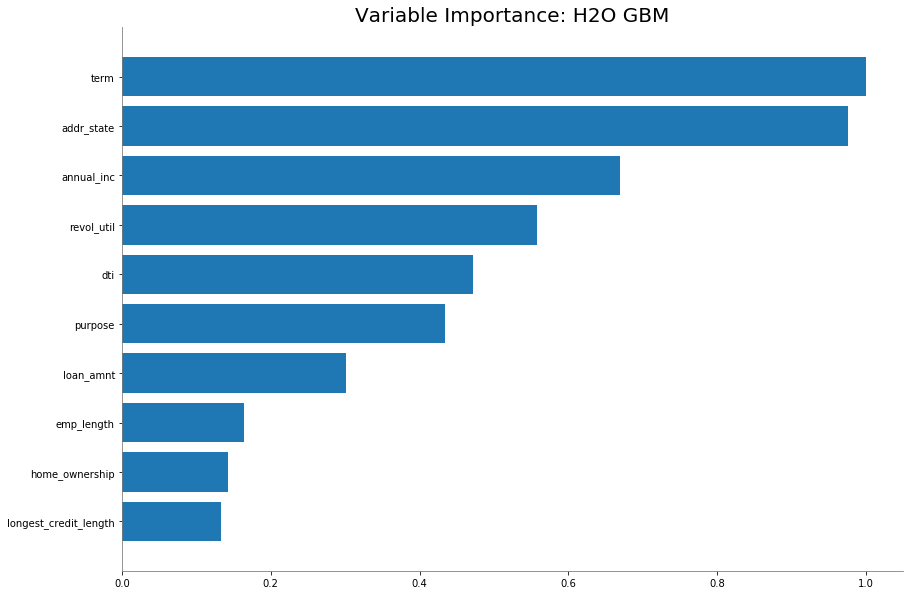

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category = matplotlib.cbook.mplDeprecation)

select_model.varimp_plot()

Note that `addr_state`, a high-cardinality categorical variable, is the most important variable. We will next try some feature engineering to see whether we can improve this model's overall performance.

# Step 4 (of 6). Feature Engineering to Improve Model Performance

The goal of this section is to improve upon these predictors through a number of feature engineering steps. In particular, we will perform four feature engineering tasks on select variables:

**Creating Target Encoding** 
   - Loan Purpose
   - State of Residence

**Separating Typical from Extreme**
   - Loan Amount
   - Annual Income
   - Debt to Income Ratio
   - Number of Delinquencies in the Past 2 Years
   - Revolving Credit Line Utilized
   - Number of Credit Lines
   - Longest Credit Length

**Creating Indicator Functions**
   - Term
   - Income Verification Status
   - Employment Length (Missing Value)

**Combining Categories** 
   - Home Ownership

## 1. Creating Target Encoding

### Cross Validation with Target Encoding

Some of the engineered features will use [cross-validated mean target encoding](https://github.com/h2oai/h2o-tutorials/blob/master/best-practices/categorical-predictors/target_encoding.md) of categorical predictors since one-hot encodings can lead to overfitting of infrequent categories.

To achieve this goal, we will first create soft partitions using H2OFrame's [`kfold_column`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html?highlight=kfold_column#h2o.frame.H2OFrame.kfold_column) function, then calculate summary statistics using H2O's [`group_by`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html#groupby) function, and finally join these engineered features using H2OFrame's [`merge`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html?highlight=merge#h2o.frame.H2OFrame.merge).

In [17]:
y = "bad_loan"
x_orig = train.col_names
x_orig.remove(y)
x_orig.remove("int_rate")

x_trans = x_orig.copy()

In [18]:
cv_nfolds = 5
cv_seed = 1234
train["cv_fold"] = train.kfold_column(n_folds = cv_nfolds, seed = cv_seed)

In [19]:
train["cv_fold"].table()

cv_fold,Count
0,24674
1,24621
2,24740
3,24478
4,24549


In [20]:
import numpy as np
import pandas as pd

In [21]:
def logit(p):
    return np.log(p) - np.log(1 - p)

In [22]:
def mean_target(data, x, y = "bad_loan"):
    grouped_data = data[[x, y]].group_by([x])
    stats = grouped_data.count(na = "ignore").mean(na = "ignore")
    return stats.get_frame().as_data_frame()

In [23]:
def mean_target_encoding(data, x, y = "bad_loan", fold_column = "cv_fold", prior_mean = 0.183, prior_count = 1):
    """
    Creates target encoding for binary target
    data (H2OFrame) : data set
    x (string) : categorical predictor column name
    y (string) : binary target column name
    fold_column (string) : cross-validation fold column name
    prior_mean (float) : proportion of 1s in the target column
    prior_count (positive number) : weight to give to prior_mean
    """ 
    grouped_data = data[[x, fold_column, y]].group_by([x, fold_column])
    grouped_data.sum(na = "ignore").count(na = "ignore")
    df = grouped_data.get_frame().as_data_frame()
    df_list = []
    nfold = int(data[fold_column].max()) + 1
    for j in range(0, nfold):
        te_x = "te_{}".format(x)
        sum_y = "sum_{}".format(y)
        oof = df.loc[df[fold_column] != j, [x, sum_y, "nrow"]]
        stats = oof.groupby([x]).sum()
        stats[x] = stats.index
        stats[fold_column] = j
        p = (stats[sum_y] + (prior_count * prior_mean)) / (stats["nrow"] + prior_count)
        stats[te_x] = logit(p)
        df_list.append(stats[[x, fold_column, te_x]])
    return h2o.H2OFrame(pd.concat(df_list))

### 1.1. Creating Target Encoding for Loan Purpose

Given that there is a high concentration of loans for debt consolidation (56.87%), a sizable number for credit card (18.78%), and the remaining 24.35% loans are spread amongst 12 other purposes, we will use mean target encoding to avoid overfitting the later group.

In [24]:
tbl = train["purpose"].table().as_data_frame()
tbl["Percent"] = np.round((100 * tbl["Count"]/train.nrows), 2)
tbl = tbl.sort_values(by = "Count", ascending = 0)
tbl = tbl.reset_index(drop = True)
print(tbl)

               purpose  Count  Percent
0   debt_consolidation  69976    56.86
1          credit_card  23082    18.76
2                other   7916     6.43
3     home_improvement   7346     5.97
4       major_purchase   3535     2.87
5       small_business   2912     2.37
6                  car   2126     1.73
7              medical   1540     1.25
8              wedding   1320     1.07
9               moving   1091     0.89
10               house    937     0.76
11            vacation    834     0.68
12         educational    303     0.25
13    renewable_energy    144     0.12


In [25]:
df = mean_target(train, "purpose")

df = df.sort_values(by = "mean_bad_loan", ascending = 0)
df = df.reset_index(drop = True)
df

,purpose,nrow,mean_bad_loan
0,small_business,2912,0.305975
1,other,7916,0.218671
2,educational,303,0.211221
3,moving,1091,0.206233
4,renewable_energy,144,0.201389
5,medical,1540,0.194156
6,debt_consolidation,69976,0.189465
7,house,937,0.177161
8,vacation,834,0.171463
9,credit_card,23082,0.155966


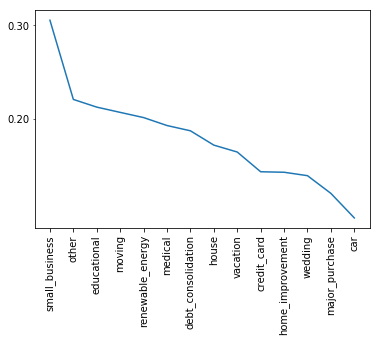

In [26]:
plt.xticks(rotation = 90)
plt.yscale("logit")
plt.plot(df["purpose"], df["mean_bad_loan"])

In [27]:
te_purpose = mean_target_encoding(train, "purpose")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [28]:
train = train.merge(te_purpose, all_x = True)

Replace `purpose` with target encoded `te_purpose`

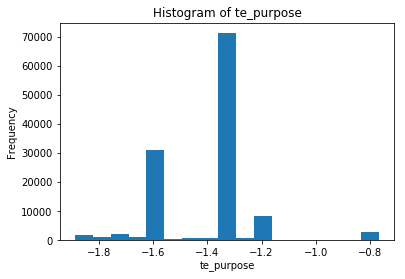

In [29]:
x_trans.remove("purpose")
x_trans.append("te_purpose")

train["te_purpose"].hist()

### 1.2. Target Encoding for State of Residence

We will also use a mean target encoding for *state of residence* for a reason similar to that for *purpose*.

In [30]:
tbl = train["addr_state"].table().as_data_frame()
tbl["Percent"] = np.round((100 * tbl["Count"]/train.nrows), 2)
tbl = tbl.sort_values(by = "Count", ascending = 0)
tbl = tbl.reset_index(drop = True)
print(tbl[0:5])

  addr_state  Count  Percent
0         CA  21493    17.47
1         NY  10699     8.69
2         TX   9188     7.47
3         FL   8554     6.95
4         NJ   4755     3.86


In [31]:
df = mean_target(train, "addr_state")

df = df.sort_values(by = "mean_bad_loan", ascending = 0)
df = df.reset_index(drop = True)
print(df[0:5])

  addr_state  nrow  mean_bad_loan
0         NE     8       0.625000
1         IA     7       0.285714
2         MS   124       0.233871
3         NV  1764       0.231859
4         TN   977       0.220061


In [32]:
print(df[45:50])

   addr_state  nrow  mean_bad_loan
45         WV   530       0.135849
46         ID     8       0.125000
47         DC   452       0.110619
48         WY   289       0.096886
49         ME     3       0.000000


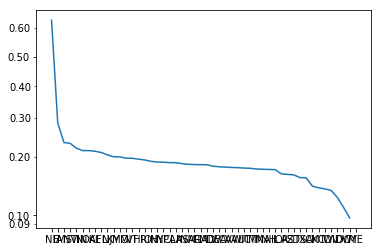

In [33]:
plt.yscale("logit")
plt.plot(df["addr_state"], df["mean_bad_loan"])

In [34]:
te_addr_state = mean_target_encoding(train, "addr_state", prior_count = 30)

Parse progress: |█████████████████████████████████████████████████████████| 100%


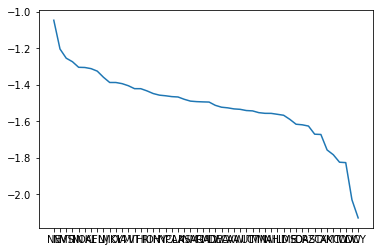

In [35]:
grouped_data = te_addr_state[["addr_state", "te_addr_state"]].group_by(["addr_state"])
df = grouped_data.count(na = "ignore").mean(na = "ignore").get_frame().as_data_frame()

df = df.sort_values(by = "mean_te_addr_state", ascending = 0)
df = df.reset_index(drop = True)

plt.plot(df["addr_state"], df["mean_te_addr_state"])

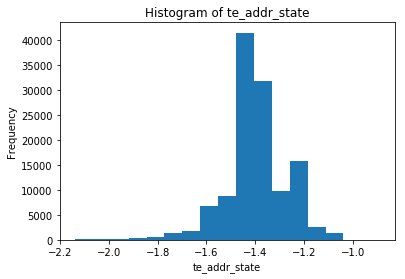

In [36]:
train = train.merge(te_addr_state, all_x = True)

x_trans.remove("addr_state")
x_trans.append("te_addr_state")

train["te_addr_state"].hist()

## 2. Separating Typical from Extreme

### 2.1. Separating Typical from Extreme Loan Amount

After binning `loan_amt` using H2OFrame's [`cut`](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/frame.html?highlight=cut#h2o.frame.H2OFrame.cut) function and looking at the fraction of bad loans on a logit scale, we see that the chance of a bad loan roughly increases linearly in loan amount from \\$5,000 to \\$30,000 and is relatively flat below \\$5,000 and above \\$30,000. To reflect this finding in the modeling, we will replace the original `loan_amnt` measure with two derived measures:

\begin{eqnarray}
\text{loan_amnt_core} & = & \max(5000, \min(\text{loan_amnt}, 30000)) \\
\text{loan_amnt_diff} & = & \text{loan_amnt} - \text{loan_amnt_core}
\end{eqnarray}

In [37]:
train["loan_amnt"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,loan_amntQuantiles
0,500
0.05,3000
0.25,7000
0.5,11400
0.75,18000
0.95,30000
1,35000


In [38]:
breaks = np.linspace(0, 35000, 8).tolist()
train["loan_amnt_cat"] = train["loan_amnt"].cut(breaks = breaks)

df = mean_target(train, "loan_amnt_cat")

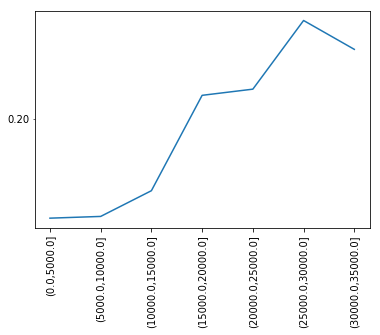

In [39]:
plt.xticks(rotation = 90)
plt.yscale("logit")
plt.plot(df["loan_amnt_cat"], df["mean_bad_loan"])

In [40]:
df

,loan_amnt_cat,nrow,mean_bad_loan
0,"(0.0,5000.0]",19317,0.163845
1,"(5000.0,10000.0]",37730,0.164431
2,"(10000.0,15000.0]",26782,0.173288
3,"(15000.0,20000.0]",18485,0.209413
4,"(20000.0,25000.0]",10829,0.211931
5,"(25000.0,30000.0]",5223,0.241432
6,"(30000.0,35000.0]",4696,0.228705


In [41]:
x_trans.remove("loan_amnt")
x_trans.append("loan_amnt_core")
x_trans.append("loan_amnt_delta")

train["loan_amnt_core"] = h2o.H2OFrame.ifelse(train["loan_amnt"] <= 5000, 5000, train["loan_amnt"])
train["loan_amnt_core"] = h2o.H2OFrame.ifelse(train["loan_amnt_core"] <= 30000, train["loan_amnt_core"], 30000)

train["loan_amnt_delta"] = train["loan_amnt"] - train["loan_amnt_core"]

### 2.2. Separating Typical from Extreme Annual Income

Looking at the occurance of bad loans on a logit scale reveal that the chance of a bad loan roughly decreases linearly in annual income from \\$10,000 to \\$105,000 and is relatively flat above \\$105,000. To reflect this finding in the modeling, we will replace the original `annual_inc` measure with two derived measures:

\begin{eqnarray}
\text{annual_inc_core} & = & \max(10000, \min(\text{annual_inc}, 105000)) \\
\text{annual_inc_diff} & = & \text{annual_inc} - \text{annual_inc_core}
\end{eqnarray}

In [42]:
train["annual_inc"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,annual_incQuantiles
0,3000
0.05,27000
0.25,45000
0.5,61000
0.75,85000
0.95,146000
1,6.1e+06


In [43]:
breaks = np.linspace(0, 150000, 31).tolist()
train["annual_inc_cat"] = train["annual_inc"].cut(breaks = breaks)

df = mean_target(train, "annual_inc_cat")

#plt.yscale("logit")
#plt.plot(df["annual_inc_cat"].index, df["mean_bad_loan"])

In [44]:
df[0:6]

,annual_inc_cat,nrow,mean_bad_loan
0,NaN,0,0.127308
1,"(0.0,5000.0]",17,0.294118
2,"(5000.0,10000.0]",145,0.213793
3,"(10000.0,15000.0]",668,0.282934
4,"(15000.0,20000.0]",1364,0.249267
5,"(20000.0,25000.0]",2929,0.235575


In [45]:
df[20:31]

,annual_inc_cat,nrow,mean_bad_loan
20,"(95000.0,100000.0]",4055,0.136128
21,"(100000.0,105000.0]",2135,0.124590
22,"(105000.0,110000.0]",2450,0.130204
23,"(110000.0,115000.0]",1428,0.111345
24,"(115000.0,120000.0]",2272,0.145246
25,"(120000.0,125000.0]",1298,0.121726
26,"(125000.0,130000.0]",1242,0.110306
27,"(130000.0,135000.0]",718,0.126741
28,"(135000.0,140000.0]",953,0.133263
29,"(140000.0,145000.0]",570,0.112281


In [46]:
x_trans.remove("annual_inc")
x_trans.append("annual_inc_core")
x_trans.append("annual_inc_delta")

train["annual_inc_core"] = h2o.H2OFrame.ifelse(train["annual_inc"] <= 10000, 10000, train["annual_inc"])
train["annual_inc_core"] = h2o.H2OFrame.ifelse(train["annual_inc_core"] <= 105000,
                                               train["annual_inc_core"], 105000)

train["annual_inc_delta"] = train["annual_inc"] - train["annual_inc_core"]

### 2.3. Separating Typical from Extreme Debt to Income Ratio

Looking at the occurance of bad loans on a logit scale reveal that the chance of a bad loan roughly increases linearly in debt-to-income from 5% to 30% and is highly volatile outside of that range due to small numbers of observations. To reflect this finding in the modeling, we will replace the original `dti` measure with two derived measures:

\begin{eqnarray}
\text{dti_core} & = & \max(5, \min(\text{dti}, 30)) \\
\text{dti_diff} & = & \text{dti} - \text{dti_core}
\end{eqnarray}

In [47]:
train["dti"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,dtiQuantiles
0,0
0.05,3.76
0.25,10.2
0.5,15.6
0.75,21.25
0.95,29.01
1,39.93


In [48]:
breaks = np.linspace(0, 40, 41).tolist()
train["dti_cat"] = train["dti"].cut(breaks = breaks)

df = mean_target(train, "dti_cat")

#plt.yscale("logit")
#plt.plot(df["dti_cat"].index, df["mean_bad_loan"])

In [49]:
df[30:41]

,dti_cat,nrow,mean_bad_loan
30,"(29.0,30.0]",1716,0.277972
31,"(30.0,31.0]",1103,0.291024
32,"(31.0,32.0]",987,0.277609
33,"(32.0,33.0]",787,0.311309
34,"(33.0,34.0]",761,0.290407
35,"(34.0,35.0]",561,0.340463
36,"(35.0,36.0]",55,0.200000
37,"(36.0,37.0]",55,0.218182
38,"(37.0,38.0]",52,0.115385
39,"(38.0,39.0]",46,0.347826


In [50]:
x_trans.remove("dti")
x_trans.append("dti_core")
x_trans.append("dti_delta")

train["dti_core"] = h2o.H2OFrame.ifelse(train["dti"] <= 5, 5, train["dti"])
train["dti_core"] = h2o.H2OFrame.ifelse(train["dti_core"] <= 30, train["dti_core"], 30)

train["dti_delta"] = train["dti"] - train["dti_core"]

### 2.4. Separating Typical from Extreme Number of Delinquencies in the Past 2 Years

The chance of a bad loan seems to max out at 3 delinquent payments in the past two years. To reflect this finding in the modeling, we will replace the original `delinq_2yrs` measure with two derived measures:

\begin{eqnarray}
\text{delinq_2yrs_core} & = & \min(\text{delinq_2yrs}, 3) \\
\text{delinq_2yrs_diff} & = & \text{delinq_2yrs} - \text{delinq_2yrs_core}
\end{eqnarray}

In [51]:
train["delinq_2yrs"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,delinq_2yrsQuantiles
0,0
0.05,0
0.25,0
0.5,0
0.75,0
0.95,1
1,18


In [52]:
breaks = np.linspace(0, 5, 6).tolist()
train["delinq_2yrs_cat"] = train["delinq_2yrs"].cut(breaks = breaks)

mean_target(train, "delinq_2yrs_cat")

,delinq_2yrs_cat,nrow,mean_bad_loan
0,NaN,0,0.180783
1,"(0.0,1.0]",12879,0.189766
2,"(1.0,2.0]",3467,0.203057
3,"(2.0,3.0]",1127,0.220941
4,"(3.0,4.0]",447,0.210291
5,"(4.0,5.0]",237,0.232068


In [53]:
x_trans.remove("delinq_2yrs")
x_trans.append("delinq_2yrs_core")
x_trans.append("delinq_2yrs_delta")

train["delinq_2yrs_core"] = h2o.H2OFrame.ifelse(train["delinq_2yrs"] <= 3, train["delinq_2yrs"], 3)

train["delinq_2yrs_delta"] = train["delinq_2yrs"] - train["delinq_2yrs_core"]

### 2.5. Separating Typical from Extreme Revolving Credit Line Utilized

The relationship between credit line utilized is somewhat interesting. There appears to be a higher rate for a bad loan when 0% of the credit lines are utilized, then it drops down slightly and roughly increases linearly in credit line utilized up to 100%. To reflect this finding in the modeling, we will replace the original `revol_util` measure with three derived measures:

\begin{eqnarray}
\text{revol_util_0} & = & I(\text{revol_util} == 0) \\
\text{revol_util_core} & = & \max(5, \min(\text{revol_util}, 30)) \\
\text{revol_util_diff} & = & \text{revol_util} - \text{revol_util_core}
\end{eqnarray}

In [54]:
train["revol_util"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,revol_utilQuantiles
0,0
0.05,8.6
0.25,35.5
0.5,55.9
0.75,74.3
0.95,92.4
1,150.7


In [55]:
breaks = np.linspace(0, 120, 25).tolist()
train["revol_util_cat"] = train["revol_util"].cut(breaks = breaks)

df = mean_target(train, "revol_util_cat")

#plt.yscale("logit")
#plt.plot(df["revol_util_cat"].index, df["mean_bad_loan"])

In [56]:
df[20:25]

,revol_util_cat,nrow,mean_bad_loan
20,"(95.0,100.0]",3214,0.254200
21,"(100.0,105.0]",173,0.231214
22,"(105.0,110.0]",28,0.250000
23,"(110.0,115.0]",7,0.285714
24,"(115.0,120.0]",3,0.000000


In [57]:
x_trans.remove("revol_util")
x_trans.append("revol_util_0")
x_trans.append("revol_util_core")
x_trans.append("revol_util_delta")

train["revol_util_0"] = train["revol_util"] == 0
train["revol_util_core"] = h2o.H2OFrame.ifelse(train["revol_util"] <= 100, train["revol_util"], 100)
train["revol_util_delta"] = train["revol_util"] - train["revol_util_core"]

### 2.6. Separating Typical from Extreme Number of Credit Lines

Looking at the occurance of bad loans on a logit scale reveal that the chance of a bad loan roughly decreases linearly in number of lines of credit up to about 50. To reflect this finding in the modeling, we will replace the original `total_acc` measure with two derived measures:

\begin{eqnarray}
\text{total_acc_core} & = & \min(\text{total_acc}, 50) \\
\text{total_acc_diff} & = & \text{total_acc} - \text{total_acc_core}
\end{eqnarray}

In [58]:
train["total_acc"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,total_accQuantiles
0,1
0.05,8
0.25,16
0.5,23
0.75,31
0.95,46
1,102


In [59]:
breaks = np.linspace(0, 60, 13).tolist()
train["total_acc_cat"] = train["total_acc"].cut(breaks = breaks)

df = mean_target(train, "total_acc_cat")

#plt.yscale("logit")
#plt.plot(df["total_acc_cat"].index, df["mean_bad_loan"])

In [60]:
(train["total_acc"] == None).table()

C1,Count
0,123039
1,23


In [61]:
df[0:3]

,total_acc_cat,nrow,mean_bad_loan
0,NaN,0,0.154404
1,"(0.0,5.0]",1753,0.225328
2,"(5.0,10.0]",9578,0.212048


In [62]:
df[8:13]

,total_acc_cat,nrow,mean_bad_loan
8,"(35.0,40.0]",8476,0.164936
9,"(40.0,45.0]",5312,0.159074
10,"(45.0,50.0]",3153,0.156359
11,"(50.0,55.0]",1755,0.142450
12,"(55.0,60.0]",972,0.166667


In [63]:
x_trans.remove("total_acc")
x_trans.append("total_acc_core")
x_trans.append("total_acc_delta")

train["total_acc_core"] = h2o.H2OFrame.ifelse(train["total_acc"] <= 50, train["total_acc"], 50)
train["total_acc_delta"] = train["total_acc"] - train["total_acc_core"]

### 2.7. Separating Typical from Extreme Longest Credit Length

Looking at the occurance of bad loans on a logit scale reveal that the chance of a bad loan roughly decreases linearly in longest credit length from 3 to 20 years and is highly volatile outside of that range due to small numbers of observations. To reflect this finding in the modeling, we will replace the original `longest_credit_length` measure with two derived measures:

\begin{eqnarray}
\text{longest_credit_length_core} & = & \max(3, \min(\text{longest_credit_length}, 20)) \\
\text{longest_credit_length_diff} & = & \text{longest_credit_length} - \text{longest_credit_length_core}
\end{eqnarray}

In [64]:
train["longest_credit_length"].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

Probs,longest_credit_lengthQuantiles
0,0
0.05,6
0.25,10
0.5,14
0.75,18
0.95,28
1,65


In [65]:
breaks = np.linspace(0, 25, 26).tolist()
train["longest_credit_length_cat"] = train["longest_credit_length"].cut(breaks = breaks)

df = mean_target(train, "longest_credit_length_cat")

#plt.yscale("logit")
#plt.plot(df["longest_credit_length_cat"].index, df["mean_bad_loan"])

In [66]:
df[0:4]

,longest_credit_length_cat,nrow,mean_bad_loan
0,NaN,0,0.171027
1,"(0.0,1.0]",48,0.270833
2,"(1.0,2.0]",72,0.333333
3,"(2.0,3.0]",700,0.208571


In [67]:
df[20:26]

,longest_credit_length_cat,nrow,mean_bad_loan
20,"(19.0,20.0]",3509,0.165004
21,"(20.0,21.0]",2968,0.158693
22,"(21.0,22.0]",2477,0.163101
23,"(22.0,23.0]",2267,0.167181
24,"(23.0,24.0]",2152,0.173792
25,"(24.0,25.0]",1839,0.162045


In [68]:
x_trans.remove("longest_credit_length")
x_trans.append("longest_credit_length_core")
x_trans.append("longest_credit_length_delta")

train["longest_credit_length_core"] = h2o.H2OFrame.ifelse(train["longest_credit_length"] <= 3,
                                                          3, train["longest_credit_length"])
train["longest_credit_length_core"] = h2o.H2OFrame.ifelse(train["longest_credit_length_core"] <= 20,
                                                          train["longest_credit_length_core"], 20)

train["longest_credit_length_delta"] = train["longest_credit_length"] - train["longest_credit_length_core"]

## 3. Create Indicator Functions

### 3.1. Converting Term to a 0/1 Indicator

Given that term of the loans are either 3 or 5 years, we will create a simplifed `term_36month` binary indicator that is 1 when the terms of the loan is for 5 years and 0 for loans with a term of 3 years.

In [69]:
train["term"].table()

term,Count
36 months,97490
60 months,25572


In [70]:
x_trans.remove("term")
x_trans.append("term_60months")

train["term_60months"] = train["term"] == "60 months"

train["term_60months"].table()

term_60months,Count
0,97490
1,25572


### 3.2. Converting Income Verification Status to a 0/1 Indicator

Given that incomes are either verified or not verified, we will create a simplifed `verified` binary indicator that is 1 when income has been verified.

In [71]:
train["verification_status"].table()

verification_status,Count
not verified,44247
verified,78815


In [72]:
x_trans.remove("verification_status")
x_trans.append("verified")

train["verified"] = train["verification_status"] == "verified"
train["verified"].table()

verified,Count
0,44247
1,78815


### 3.3. Creating Missing Value Indicator for Employment Length

The most interesting characteristic about employment length is whether or not it is missing. The divide between those with missing values for employment length to those who have a recorded employment length is 26.3% bad loans to 18.0% bad loans respectively. Interestingly, there doesn't appear to be any differences in bad loans across employment lengths.

In [73]:
train["emp_length"].summary()

,emp_length
type,int
mins,0.0
mean,5.6807001583611205
maxs,10.0
sigma,3.610320673601871
zeros,10727
missing,4346
0,nan
1,7.0
2,2.0


In [74]:
x_trans.append("emp_length_missing")
train["emp_length_missing"] = train["emp_length"] == None

mean_target_encoding(train, "emp_length_missing")

Parse progress: |█████████████████████████████████████████████████████████| 100%


emp_length_missing,cv_fold,te_emp_length_missing
0,0,-1.52085
1,0,-1.0216
0,1,-1.51402
1,1,-1.06329
0,2,-1.51493
1,2,-1.03287
0,3,-1.51542
1,3,-0.986137
0,4,-1.51821
1,4,-1.01942


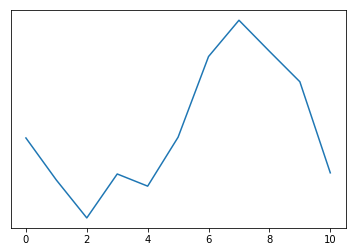

In [75]:
df = mean_target(train, "emp_length")

plt.yscale("logit")
plt.plot(df["emp_length"], df["mean_bad_loan"])

In [76]:
df

,emp_length,nrow,mean_bad_loan
0,NaN,0,0.264151
1,0.0,10727,0.180852
2,1.0,8506,0.176699
3,2.0,11877,0.173023
4,3.0,10243,0.177292
5,4.0,8285,0.176101
6,5.0,9313,0.180930
7,6.0,7472,0.189106
8,7.0,6766,0.192876
9,8.0,5584,0.189649


## 4. Combining Categories
### 4.1.  Combining Categories in Home Ownership

Although there are 6 recorded categories within home ownership, only three had over 200 observations: OWN, MORTGAGE, and RENT. The remaining three are so infrequent we will combine them {ANY, NONE, OTHER} with RENT to form an enlarged OTHER category. This new `home_ownership_3cat` variable will have values in {MORTGAGE, OTHER, OWN}.

In [77]:
mean_target(train, "home_ownership")

,home_ownership,nrow,mean_bad_loan
0,MORTGAGE,59901,0.162835
1,NONE,27,0.259259
2,OTHER,116,0.215517
3,OWN,10165,0.189670
4,RENT,52853,0.204284


In [78]:
lvls = ["OTHER", "MORTGAGE", "OTHER", "OTHER", "OWN", "OTHER"]
train["home_ownership_3cat"] = train["home_ownership"].set_levels(lvls).ascharacter().asfactor()

train[["home_ownership", "home_ownership_3cat"]].table()

home_ownership,home_ownership_3cat,Counts
MORTGAGE,MORTGAGE,59901
NONE,OTHER,27
OTHER,OTHER,116
OWN,OWN,10165
RENT,OTHER,52853


In [79]:
mean_target(train, "home_ownership_3cat")

,home_ownership_3cat,nrow,mean_bad_loan
0,MORTGAGE,59901,0.162835
1,OTHER,52996,0.204336
2,OWN,10165,0.189670


In [80]:
x_trans.remove("home_ownership")
x_trans.append("home_ownership_3cat")

# Step 5. Train Models using Transformed Data

The transformed variables are

In [81]:
x_trans

['emp_length',
 'te_purpose',
 'te_addr_state',
 'loan_amnt_core',
 'loan_amnt_delta',
 'annual_inc_core',
 'annual_inc_delta',
 'dti_core',
 'dti_delta',
 'delinq_2yrs_core',
 'delinq_2yrs_delta',
 'revol_util_0',
 'revol_util_core',
 'revol_util_delta',
 'total_acc_core',
 'total_acc_delta',
 'longest_credit_length_core',
 'longest_credit_length_delta',
 'term_60months',
 'verified',
 'emp_length_missing',
 'home_ownership_3cat']

We not fit a new set of models using AutoML

In [82]:
aml_trans = H2OAutoML(max_models = 6, exclude_algos = ['DeepLearning'])
aml_trans.train(x = x_trans, y = y, training_frame = train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [83]:
print(aml_trans.leaderboard)

model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20190810_030023,0.683187,0.445311,0.366106,0.374137,0.139979
StackedEnsemble_BestOfFamily_AutoML_20190810_030023,0.682768,0.445429,0.366194,0.374178,0.140009
GBM_1_AutoML_20190810_030023,0.682335,0.44421,0.366826,0.37384,0.139756
XGBoost_3_AutoML_20190810_030023,0.680107,0.445485,0.368822,0.374131,0.139974
XGBoost_1_AutoML_20190810_030023,0.678347,0.445413,0.372374,0.374431,0.140199
GLM_grid_1_AutoML_20190810_030023_model_1,0.67685,0.445642,0.371519,0.374368,0.140151
XGBoost_2_AutoML_20190810_030023,0.673935,0.447162,0.373206,0.375148,0.140736
DRF_1_AutoML_20190810_030023,0.662424,0.452211,0.383423,0.377208,0.142286


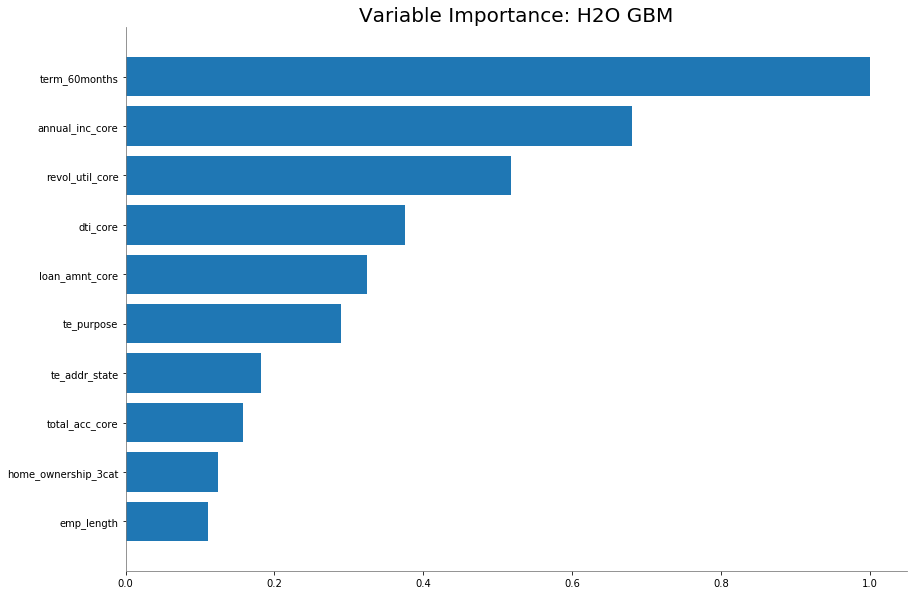

In [84]:
best_model_trans = h2o.get_model(aml_trans.leaderboard[2,'model_id'])
best_model_trans.varimp_plot()

In [86]:
print("AUC (orig): train = {:.4f}, xval = {:.4f}" \
      .format(best_model_trans.auc(train = True),
              best_model_trans.auc(xval = True)))

AUC (orig): train = 0.7139, xval = 0.6823


# Step 6 (of 6). Shutdown H2O Cluster

In [316]:
h2o.cluster().shutdown()

H2O session _sid_9b86 closed.
